In [1]:
#Set the devices which Jax should use. 
#This must be done before importing jax
import os
# --- Control Flag ---
USE_GPU = False
# --------------------

if USE_GPU:
    # Set JAX to use the GPU. The device number (0) is for the first GPU.
    os.environ['JAX_PLATFORMS'] = 'cuda,cpu'
    # Optional: Pin JAX to a specific GPU
    os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
else:
    os.environ['JAX_PLATFORMS'] = 'cpu'
    import numpyro
    numpyro.set_host_device_count(4)
    

import jax
print(f"JAX is running on: {jax.default_backend()}")
print(f"JAX devices: {jax.devices()}")

import finitediffx as fdx
import pandas as pd
import numpyro
from niceode.pymc_utils import make_pymc_model
import pymc as pm
from niceode.utils import (CompartmentalModel, 
                           ODEInitVals,
                           PopulationCoeffcient,
                           neg2_log_likelihood_loss,
                           ObjectiveFunctionColumn,
                           FOCE_approx_ll_loss,
                           FOCEi_approx_ll_loss,
                           FO_approx_ll_loss
                           )
from niceode.diffeqs import OneCompartmentAbsorption
import numpy as np
import joblib as jb
from niceode.jax_utils import FO_approx_neg2ll_loss_jax

/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


JAX is running on: cpu
JAX devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]


In [2]:
df = pd.read_csv(r"/workspaces/PK-Analysis/data/theo_nlmixr2.csv", ) 
df.loc[df['AMT'] == 0.0, 'AMT'] = pd.NA
df['AMT'] = df['AMT'].ffill()
df = df.loc[df['EVID'] == 0, :].copy()

In [3]:
me_mod_fo =  CompartmentalModel(
        model_name = "debug_theoph_abs_ka-clME-vd_JAXFOCE_jaxoptspwrapLbfgsb_fdxouteriftinner_nodep_omegadiag_dermal",
            ode_t0_cols=[ ODEInitVals('DV'), ODEInitVals('AMT'),],
            conc_at_time_col = 'DV',
            subject_id_col = 'ID', 
            time_col = 'TIME',
            population_coeff=[
                                PopulationCoeffcient('ka', 
                                                    optimization_init_val=1.6, 
                                                    subject_level_intercept=True,
                                                    #optimization_lower_bound = np.log(1e-6),
                                                    #optimization_upper_bound = np.log(15),
                                                    subject_level_intercept_sd_init_val = 0.6, 
                                                    #subject_level_intercept_sd_upper_bound = 20,
                                                    #subject_level_intercept_sd_lower_bound=1e-6
                                                    ),
                                PopulationCoeffcient('cl',
                                                    optimization_init_val = 3,
                                                    #optimization_lower_bound = np.log(1e-4),
                                                    #optimization_upper_bound=np.log(25),
                                                    subject_level_intercept=True, 
                                                    subject_level_intercept_sd_init_val = 0.3, 
                                                   # subject_level_intercept_sd_upper_bound = 5,
                                                   # subject_level_intercept_sd_lower_bound=1e-6
                                                    ),
                                PopulationCoeffcient('vd', optimization_init_val = 35,
                                                    #, optimization_lower_bound = np.log(.1)
                                                    #,optimization_upper_bound=np.log(80), 
                                                    subject_level_intercept=True, 
                                                    subject_level_intercept_sd_init_val = 0.1, 
                                                    #subject_level_intercept_sd_upper_bound = 5,
                                                    #subject_level_intercept_sd_lower_bound=1e-6
                                                    
                                                    #, optimization_upper_bound = np.log(.05)
                                                    ),
                            ],
            dep_vars= None, 

                                    pk_model_class=OneCompartmentAbsorption, 
                                    model_error_sigma=PopulationCoeffcient('sigma'
                                                                            ,log_transform_init_val=False
                                                                            , optimization_init_val=.5
                                                                            ,optimization_lower_bound=0.00001
                                                                            ,optimization_upper_bound=3
                                                                            ),
  
                                    batch_id='theoph_test1',

                                    significant_digits=3,
                                    #me_loss_function=FO_approx_ll_loss,
                                    jax_loss=FO_approx_neg2ll_loss_jax,
                                    use_full_omega=True, 
                                    use_surrogate_neg2ll=True, 
                                    fit_jax_objective=True,
                                    )

In [4]:
model = make_pymc_model(me_mod_fo,
                            fit_df = df,
                            link_function = 'exp',
                            use_existing_fit = False,
                            )

Successfully compiled closed stiff ODE solver
Sucessfully complied non-stiff ODE solver
Sucessfully complied augmented dynamics stiff ODE solver


2025/09/10 20:52:43 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Creating Schema with empty inputs is not allowed.


Sucessfully complied augmented dynamics stiff ODE solver
Sucessfully complied stiff ODE solver
Sucessfully complied KEYS stiff ODE solver
Sucessfully complied non-stiff PyMC ODE solver
Sucessfully complied hybrid-dimensional non-stiff PyMC ODE solver
Sucessfully complied non-dimensional non-stiff PyMC ODE solver
Sucessfully complied non-dimensional stiff PyMC ODE solver
Sucessfully complied stiff PyMC ODE solver
🏃 View run b-theoph_test1_m-debug_theoph_abs_ka-clME-vd_JAXFOCE_jaxoptspwrapLbfgsb_fdxouteriftinner_nodep_omegadiag_dermal_f-aa65c092-902d-4a85-9907-9fb359cb17be at: http://mlflow-server:5000/#/experiments/377/runs/9f19c6742f2d4cd4b483fa7473c7293d
🧪 View experiment at: http://mlflow-server:5000/#/experiments/377
Compiling `_solve_ivp_jax_worker`


Compiling `_solve_ivp_jax_worker`


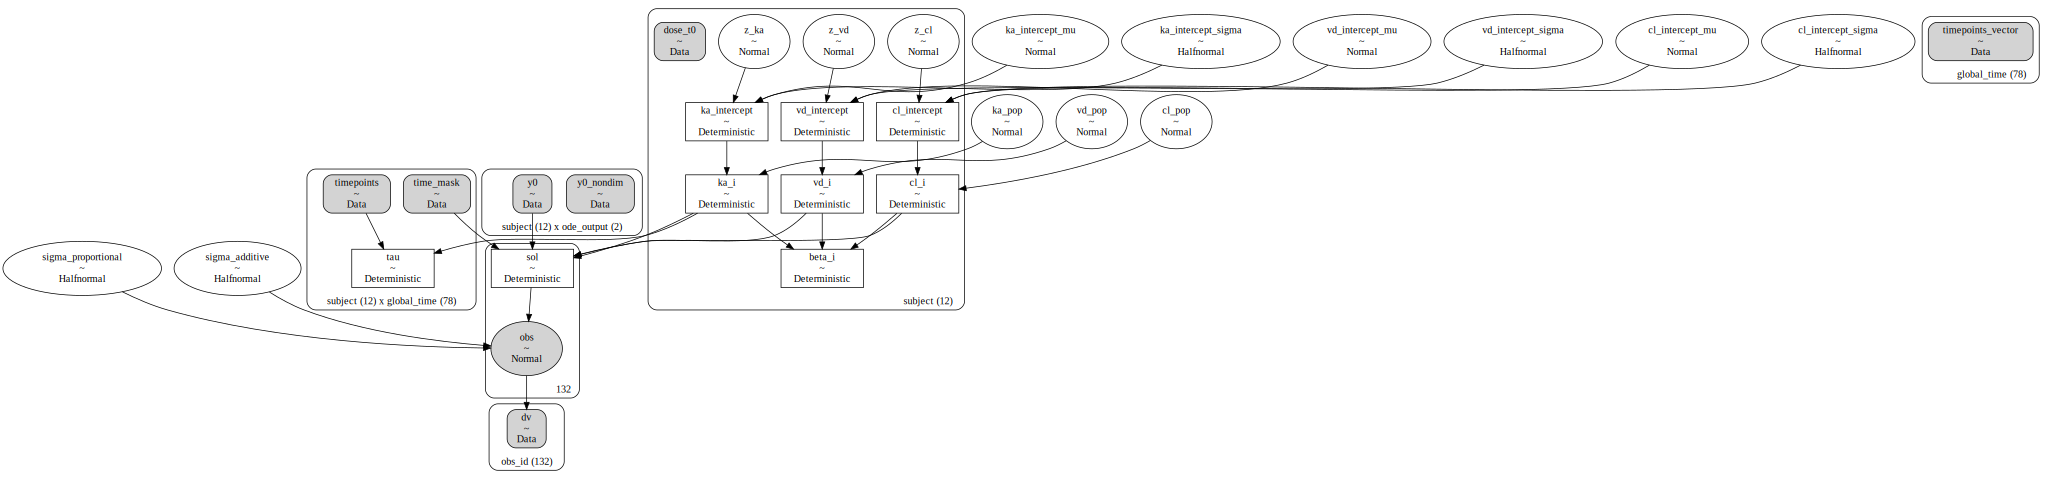

In [5]:
pm.model_to_graphviz(model)

In [6]:

chains = 4
tune = 2000
total_draws = 6000
draws = np.round(total_draws / chains, 0).astype(int)
with model:
    trace_NUTS = pm.sample(
        tune=tune,
        draws=draws,
        chains=chains,
        nuts_sampler="numpyro",
        target_accept=0.92, 
    )

Compiling `_solve_ivp_jax_worker`
Compiling `_solve_ivp_jax_worker`


Compiling.. :   0%|          | 0/3500 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/3500 [00:05<?, ?it/s]


Running chain 0:   5%|▌         | 175/3500 [05:35<1:44:31,  1.89s/it]




Running chain 0:  10%|█         | 350/3500 [09:17<1:19:53,  1.52s/it]


Running chain 0:  15%|█▌        | 525/3500 [12:48<1:08:21,  1.38s/it]


Running chain 0:  20%|██        | 700/3500 [15:41<57:11,  1.23s/it]  


Running chain 0:  25%|██▌       | 875/3500 [18:40<50:20,  1.15s/it]


Running chain 0:  30%|███       | 1050/3500 [21:38<45:11,  1.11s/it]


Running chain 0:  35%|███▌      | 1225/3500 [25:03<42:45,  1.13s/it]


Running chain 0:  40%|████      | 1400/3500 [27:56<37:53,  1.08s/it]


Running chain 0:  45%|████▌     | 1575/3500 [30:49<33:49,  1.05s/it]


Running chain 0:  50%|█████     | 1750/3500 [34:03<31:12,  1.07s/it]


Running chain 0:  55%|█████▌    | 1925/3500 [37:14<28:15,  1.08s/it]



Running chain 0:  60%|██████    | 2100/3500 [40:45<26:01,  1.12s/it]


Running chain 0:  65%|

In [55]:
df_summ = pm.summary(trace_NUTS)

/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning:

invalid value encountered in scalar divide

/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning:

invalid value encountered in scalar divide

/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning:

invalid value encountered in scalar divide

/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning:

invalid value encountered in scalar divide

/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning:

invalid value encountered in scalar divide

/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning:

invalid value encountered in scalar divide

/opt/poetry-venv

In [56]:
df_summ

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ka_pop,0.470,0.292,-0.086,1.005,0.004,0.004,5469.0,4331.0,1.0
ka_intercept_mu,-0.058,0.357,-0.703,0.637,0.007,0.004,2753.0,3738.0,1.0
z_ka[1],0.134,0.394,-0.651,0.819,0.008,0.005,2417.0,4055.0,1.0
z_ka[2],0.388,0.423,-0.379,1.195,0.008,0.005,2512.0,4034.0,1.0
z_ka[3],0.592,0.433,-0.217,1.388,0.009,0.006,2458.0,3756.0,1.0
...,...,...,...,...,...,...,...,...,...
sol[127],8.018,0.484,7.112,8.911,0.008,0.005,3594.0,4145.0,1.0
sol[128],6.777,0.400,6.063,7.556,0.006,0.004,4496.0,4770.0,1.0
sol[129],5.678,0.343,5.072,6.339,0.004,0.004,6589.0,5034.0,1.0
sol[130],4.306,0.324,3.699,4.901,0.003,0.004,9489.0,4696.0,1.0


/opt/poetry-venvs/niceode-fa7VnN3D-py3.13/lib/python3.13/site-packages/arviz/plots/traceplot.py:223: UserWarning:

rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (23), generating only 20 plots



array([[<Axes: title={'center': 'ka_pop'}>,
        <Axes: title={'center': 'ka_pop'}>],
       [<Axes: title={'center': 'ka_intercept_mu'}>,
        <Axes: title={'center': 'ka_intercept_mu'}>],
       [<Axes: title={'center': 'z_ka'}>,
        <Axes: title={'center': 'z_ka'}>],
       [<Axes: title={'center': 'cl_pop'}>,
        <Axes: title={'center': 'cl_pop'}>],
       [<Axes: title={'center': 'cl_intercept_mu'}>,
        <Axes: title={'center': 'cl_intercept_mu'}>],
       [<Axes: title={'center': 'z_cl'}>,
        <Axes: title={'center': 'z_cl'}>],
       [<Axes: title={'center': 'vd_pop'}>,
        <Axes: title={'center': 'vd_pop'}>],
       [<Axes: title={'center': 'vd_intercept_mu'}>,
        <Axes: title={'center': 'vd_intercept_mu'}>],
       [<Axes: title={'center': 'z_vd'}>,
        <Axes: title={'center': 'z_vd'}>],
       [<Axes: title={'center': 'ka_intercept_sigma'}>,
        <Axes: title={'center': 'ka_intercept_sigma'}>],
       [<Axes: title={'center': 'cl_intercep

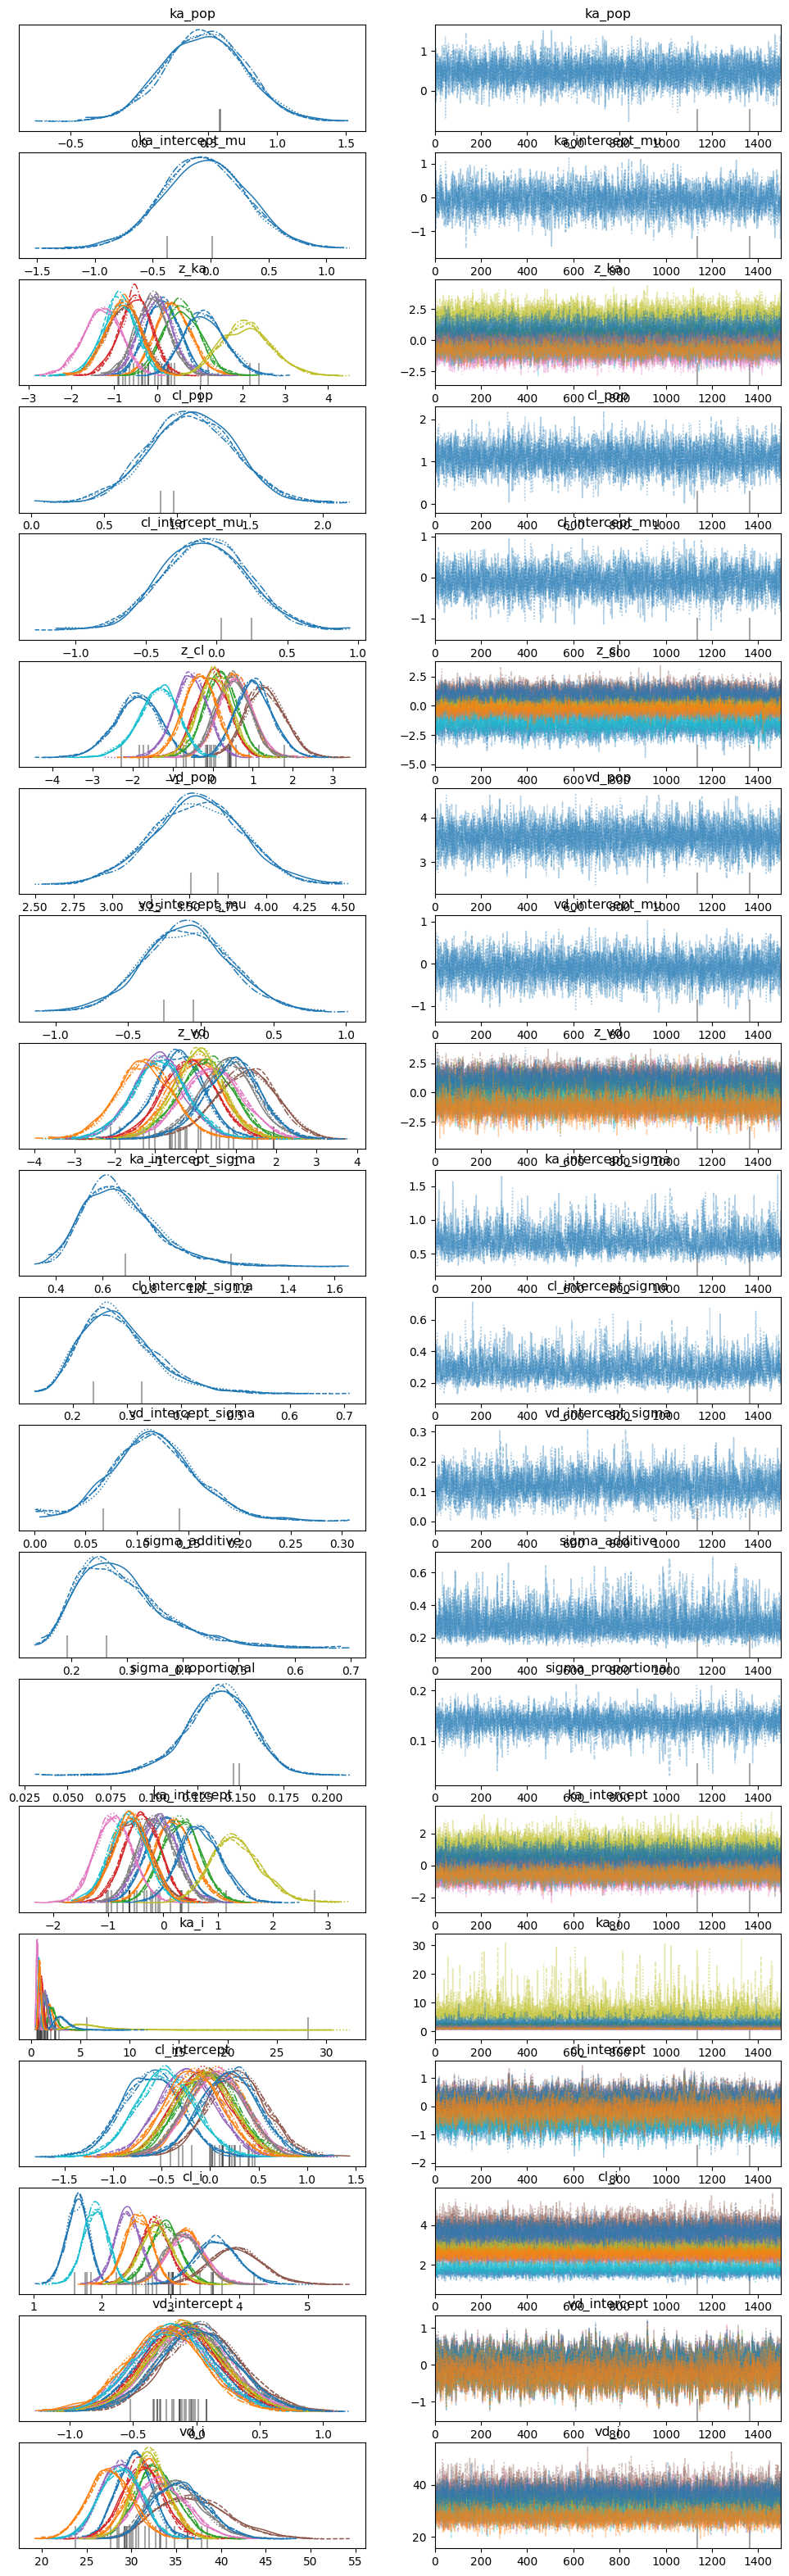

In [35]:
pm.plot_trace(trace_NUTS)

In [49]:
pred_df = df[['ID','DV', 'TIME']].copy()

In [43]:
df_summ = df_summ.reset_index()
df_summ = df_summ.loc[df_summ['index'].str.contains('sol')]

In [50]:

pred_df['heirarch_IPRED'] = df_summ['mean'].to_numpy()
pred_df['heirarch_IPRED_ciLOWER'] = df_summ['hdi_3%'].to_numpy()
pred_df['heirarch_IPRED_ciUPPER'] = df_summ['hdi_97%'].to_numpy()

In [51]:
pred_df = pred_df.melt(id_vars = ['ID', 'TIME'], value_vars = ['DV', 'heirarch_IPRED', 'heirarch_IPRED_ciLOWER', 'heirarch_IPRED_ciUPPER'])

In [52]:
pred_df

,ID,TIME,variable,value
0,1,0.00,DV,0.740
1,1,0.25,DV,2.840
2,1,0.57,DV,6.570
3,1,1.12,DV,10.500
4,1,2.02,DV,9.660
...,...,...,...,...
523,12,5.07,heirarch_IPRED_ciUPPER,8.911
524,12,7.07,heirarch_IPRED_ciUPPER,7.556
525,12,9.03,heirarch_IPRED_ciUPPER,6.339
526,12,12.05,heirarch_IPRED_ciUPPER,4.901


In [53]:
import plotly.express as px

px.line(data_frame=pred_df, x = 'TIME', y = 'value', animation_frame='ID', color = 'variable')

In [34]:
df_summ

,index,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,ka_pop,0.470,0.292,-0.086,1.005,0.004,0.004,5469.0,4331.0,1.0
1,ka_intercept_mu,-0.058,0.357,-0.703,0.637,0.007,0.004,2753.0,3738.0,1.0
2,z_ka[1],0.134,0.394,-0.651,0.819,0.008,0.005,2417.0,4055.0,1.0
3,z_ka[2],0.388,0.423,-0.379,1.195,0.008,0.005,2512.0,4034.0,1.0
4,z_ka[3],0.592,0.433,-0.217,1.388,0.009,0.006,2458.0,3756.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1194,sol[127],8.018,0.484,7.112,8.911,0.008,0.005,3594.0,4145.0,1.0
1195,sol[128],6.777,0.400,6.063,7.556,0.006,0.004,4496.0,4770.0,1.0
1196,sol[129],5.678,0.343,5.072,6.339,0.004,0.004,6589.0,5034.0,1.0
1197,sol[130],4.306,0.324,3.699,4.901,0.003,0.004,9489.0,4696.0,1.0
